Author: Kemal Yilmaz <br />
10/28/2019

# CONTENT
## 1. Data Exploration
## 2. Building various functions (adjusted r2, MSE, train_test_split, outlier_detection etc)
## 3. Linear Regression with Normal Equation
## 4. Developing different models with different datasets cleaned differently
## 5. Linear Regression with Stochastic Gradient Descent
## 6. Diagnostics of Linear Regression
## 7. From Linear Regression to Polynomial Regression

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Data Exploration

In [2]:
df = pd.read_excel("../input/Adops & Data Scientist Sample Data.xlsx", sheet_name = "Q2 Regression", header = None)

In [3]:
df.head()

,0,1,2
0,0.490142,-0.179654,11.536508
1,-1.414793,-1.225605,11.828531
2,0.943066,4.506148,-3.235349
3,3.569090,5.068347,-23.891922
4,-1.702460,6.905051,-22.125437


In [4]:
# Renaming columns
df.rename(columns={0: 'A', 1: 'B', 2: 'C'}, inplace= True)
df.head()

,A,B,C
0,0.490142,-0.179654,11.536508
1,-1.414793,-1.225605,11.828531
2,0.943066,4.506148,-3.235349
3,3.569090,5.068347,-23.891922
4,-1.702460,6.905051,-22.125437


In [5]:
df.info()

# df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
A    300 non-null float64
B    300 non-null float64
C    300 non-null float64
dtypes: float64(3)
memory usage: 7.1 KB


In [6]:
df.describe()

,A,B,C
count,300.000000,300.000000,300.000000
mean,2.316688,2.012932,-41.567544
std,5.694549,2.998603,581.196205
min,-8.859235,-2.891623,-9999.000000
25%,-1.937274,-0.605841,-23.354257
50%,0.468780,1.935227,-3.087428
75%,7.041309,4.698202,16.303241
max,20.558194,6.997177,202.022916


Column C has a very extreme minimum. 
Also, it seems to have a very different data structure that the others.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BDDA2CBB70>,
      dtype=object)

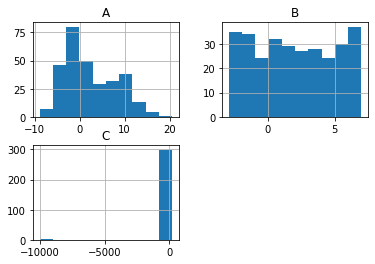

In [7]:
## Check distribution of data
df.hist()

All columns have a different distribution. <br />
Column A has somehow bimodal distribution while Column B has a uniform distribution. <br />
Column C has an extreme outlier.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BDDA0AA860>,
      dtype=object)

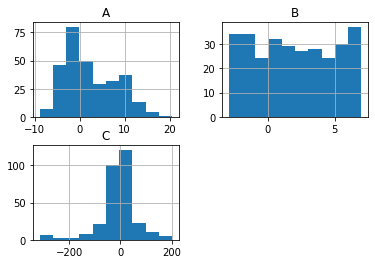

In [8]:
## Quick and dirty approach to remove min in Column C to see if the outlier is filtered out
df[df['C'] !=  df['C'].min()].hist()

We are lucky! After removing extreme minimum outlier in Column C, it has a more interpretable distribution. Now, it is a left skewed distribution. Also, it might have more outlier. <br /> 
Moreover, instead of having bell shape, the data have less variance (thin and tall shape).

In [9]:
## Let's keep this dataframe to use later while running the model for different dataframes.
df_1 = df[df['C'] !=  df['C'].min()]

## This is necessary when intercept column is added to the dataframe 
df_1.reset_index(drop= True, inplace = True)

Text(0, 0.5, 'Column C')

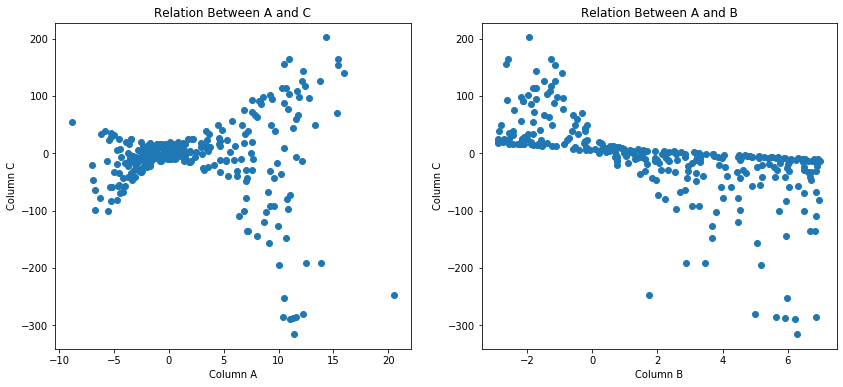

In [10]:
## Relation between dependant and independant variables

plt.subplots(2,2,figsize=(14,6))

plt.subplot(1, 2, 1)
plt.scatter(df_1['A'], df_1['C'])
plt.title('Relation Between A and C')
plt.xlabel('Column A')
plt.ylabel('Column C')

plt.subplot(1, 2, 2)
plt.scatter(df_1['B'], df_1['C'])
plt.title('Relation Between A and B')
plt.xlabel('Column B')
plt.ylabel('Column C')



The relation does not seem to be linear. Although we will start with a multiple linear regression at the first attempt, we will very likely need to transform the varibles. 

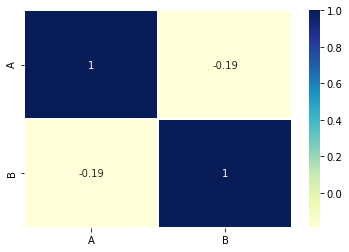

In [11]:
## Correlation heatmap
sns.heatmap(df[['A', 'B']].corr(), annot = True, linewidths = 0.5, cmap = "YlGnBu")

Having high correlation between independant variables should alert which might cause a multicollinearity - although it is not always the case. Here, Column A and Column B have a low correlation.

## 2. Building Various Functions

In [12]:
## Although min in Column C was removed, it might be necessary to write a function to remove outliers systematically.

def outlier_detection(data, outlier_range = 1.5):
    
    '''
    
    This function removes outliers in all columns of the data frame based on the distance of the data point to 
    the first quartile (to the left) and to the third quartile (to the right).
    
    data   (pandas dataframe)  : Dataframe to the processed
    outlier_range     (float)  : Distance from the first quartile, or the third quartile. By default, it is 1.5, which is
    usually the rule-of-thumb. However, this range can change regarding domain expertise and charachteristic of the data, 
    especially when the data is extremely skewed.
    
    The function returns a modified dataframe that has no outlier regarding outlier_range
    
    '''
    
    print('Outlier removal when outlier_range is {}.'.format(outlier_range))
    print('Initial row count: {}'.format(len(data)))
    

    for col in data.columns:
        q1, q3= np.percentile(data[col],[25,75])
        iqr = q3 - q1
        lower_bound = q1 -(outlier_range * iqr) 
        upper_bound = q3 +(outlier_range * iqr)
          
        data = data[(data[col] > lower_bound) & (data[col] < upper_bound)]
        print('Row count after removing outliers in Column {}: {}'.format(col,len(data)))
        
    ## Since some rows are removed, it is better to reset the index to not have an issue in the later steps.    
    data.reset_index(drop= True, inplace = True)
            
    return data

In [13]:
df_2 = outlier_detection(df)
print("-----------------------")
df_3 = outlier_detection(df,2.5)
print("-----------------------")
df_4 = outlier_detection(df,3.0)
print("-----------------------")
df_5 = outlier_detection(df,4.0)


Outlier removal when outlier_range is 1.5.
Initial row count: 300
Row count after removing outliers in Column A: 299
Row count after removing outliers in Column B: 299
Row count after removing outliers in Column C: 246
-----------------------
Outlier removal when outlier_range is 2.5.
Initial row count: 300
Row count after removing outliers in Column A: 300
Row count after removing outliers in Column B: 300
Row count after removing outliers in Column C: 272
-----------------------
Outlier removal when outlier_range is 3.0.
Initial row count: 300
Row count after removing outliers in Column A: 300
Row count after removing outliers in Column B: 300
Row count after removing outliers in Column C: 278
-----------------------
Outlier removal when outlier_range is 4.0.
Initial row count: 300
Row count after removing outliers in Column A: 300
Row count after removing outliers in Column B: 300
Row count after removing outliers in Column C: 287


Defining outlier is reliant on the domain and data scientist's discretion. Outlier range of 1.5 is the standard to determine the mild outliers in most of the software (3 for extreme outliers). However, range can be adjusted regarding the business requirement and knowledge. <br />
We will create different models by using all these dataframes. <br />
Note that df_1 and df_2 have the same number of rows, which means they are the same dataset.

In [14]:
## Models will be built on train data, and be validated on test data. 
## For simplicity, cross validation function is not developed from scratch, hence cross validation methodology, 
## i.e. 10 fold, is not utilized in the notebook.

def train_test_split(X, y, test_ratio = 0.33, seed = None):
    
    '''
    
    This function splits the given independant and dependant variables as train and test split.
    
    X   (pandas dataframe)  : Independant variables
    y               (list)  : Dependant variable
    test_ratio     (float)  : Size of test data divided by total instance
    seed        (integer)   : If wanted to obtain the same train and test split at each run, seed should be set. This ensures
    the repeatibility of the function

    The function return 4 different dataframes which are X_train, X_test, Y_train and Y_test
    
    '''    
    
    # For repeability, seed can be set.
    if seed:
        np.random.seed(seed)
        
    # Shuffling indices
    shuffled_indices = np.random.permutation(len(X))
    
    # Calculating test size
    test_size = int(len(X)*test_ratio)
    
    # Based on test size, retriving test indices
    test_indices = shuffled_indices[:test_size].tolist()
    
    # Rest of the indices, which are train indices
    train_indices = list(set(shuffled_indices) - set(test_indices))
    
    # Slicing independant variables
    X_train_data = X.iloc[train_indices]
    X_test_data = X.iloc[test_indices]

    # Slicing dependat variables
    y_train_data = y[train_indices]
    y_test_data = y[test_indices]

    return X_train_data, X_test_data, y_train_data, y_test_data

train_test_split used in this notebook is a simple permutation of all instances, which means it is not as sophisticated as Sklearn's methodology. Being that simple, i.e. lack of randomness, can sometimes cause non-ideal split which might result in a difference between r2 of train and test data. If the discrepany is high, this might be indication of overfitting (high r2 for train, relatively low r2 test). All you need is re-running the train_test_split and the model. <br /> <br />
As a side note, if you use Sklearn's train_test_split, you will always get a closer r2 values for train and test split.

<br />
Scaling would convert data into the same scale which would help compare the importance of independant variables by checking
the coefficient. The greater coefficient (beta) means the more important independantvariable. It alsa improves the efficiency
since the values would be smaller and easy to compute. <br />
<br />
There are different ways of scaling, i.e min-max scaling,normalization, standardization. In linear regression, standard scaling
is usually better since the model relies on normality assumption. Also, standard scaling does not compress the outliers
as most of scalers do.


In [15]:
# Although the function is defined here, it will not be used for now. If wanted, it can be used later.

def standard_scaler(train_data, test_data):
    
    '''
    
    This function scales input dataframes by mean and standard deviation of each corresponding feature. That is
            
            df[col_scale] = (df[col] - df[col].mean()) / df[col].std()
            
    which is actually the z-score of each corresponding observation in that column.
    
    train_data (pandas dataframe)  : Train data to be scaled
    test_data  (pandas dataframe)  : Test data to be scaled

    The function return 2 different dataframes which are scales versions of train and test data.
    
    Note that the function can easily modified to retrieve the mean and standard deviation, if desired.
    
    '''   
    
    
    train_df_new = pd.DataFrame(columns = train_data.columns, index = list(train_data.index.values))
    test_df_new = pd.DataFrame(columns = test_data.columns, index = list(test_data.index.values))

    # If wanted to return mean and standard deviation of the scaler
    mean_list = list()
    std_list = list()
    
    # Standard scaling train data 
    for col in train_df_new.columns:
        
        # Calculating mean and std for train data, which would also be used for test data. 
        std = train_data[col].std()
        mean = train_data[col].mean()

        train_df_new[col] = (train_data[col] - mean)/std
        
        mean_list.append(mean)
        std_list.append(std)
        
    # Standard scaling test data
    for col in test_df_new.columns:
        
        test_df_new[col] = (test_data[col] - mean)/std
        
    ## If mean and standar deviation of scaler are desired to be retrieved, just include the mean_list and std_list below.
    return train_df_new, test_df_new  ##, mean_list, std_list
        

In [16]:
## Some functions for prediction and performance measure. Not all measures are used. Can be used if desired.

# Predictions
def predict(X,betas):
    
    '''
    
    This function calculates prediction based on input features and the corresponding coefficients by using dot product.
            
    
    X  (pandas dataframe)  : Input features
    betas         (array)  : Coefficients of features 

    The function returns prediction for the corresponsding observation.
    
    '''       
    
    # linear_algorithm() function adds intercept column to train data however it is not modefied. Both train and test data 
    # need to have an intercept column for predictions.
    if 'intercept' not in X.columns:
        m = len(X)
        x0 = pd.DataFrame(np.ones((m,1)), columns = ['intercept'], index = list(X.index.values))
        X = pd.concat([x0, X], axis=1)   

    yhat = X.dot(betas)
    return yhat

## The rest are standard evalulation metrics, so no explanation (docstring) was added in the functions  

# Model Evaluation - RMSE
def rmse(Y, Yhat):
    rmse = np.sqrt(sum((Y - Yhat) ** 2) / len(Y))
    return rmse

# Model Evaluation - RMSE
def mse(Y, Yhat):
    rmse = sum((Y - Yhat) ** 2) / len(Y)
    return rmse

# Model Evaluation - R2 Score
def r2_score(Y, Yhat):
    mean_y = np.mean(Y)
    ss_tot = sum((Y - mean_y) ** 2)
    ss_res = sum((Y - Yhat) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

# It is better to check adjusted r2 in multiple linear regression
def adjusted_r2(X,Y,Yhat):
    
    # First part is r2 calculation
    mean_y = np.mean(Y)
    ss_tot = sum((Y - mean_y) ** 2)
    ss_res = sum((Y - Yhat) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Here is adjusted r2
    adj_r2 = 1 - (1-r2)*(X.shape[0]-1)/(X.shape[0]-2-1)
        
    ###Should this X be original X or the one with intercept. Compare with the output of OLS
    return adj_r2

## 3. Linear Regression with Normal Equation

Normal Equation is a closed-form solution, which is an analytical approach for Linear Regression with a Least Square Cost function. The beauty of this approach is that it directly gives coefficients without using Gradient Descent. It is fast and exact solution if the dataset is small. <br /> <br />
However, in the era of big data, there can be thousands of features in the model. In that case Normal Equation approach would likely take long time since taking inverse of such a big matrix is a gruesome process. 
Normal Equation that gives coefficients is as follows:

\begin{equation*}
\beta = (X^{T}.X)^{-1} . (X^T. y)
\end{equation*}

where;
  - beta is coefficient vector of n features
  - X is feature matrix (independant variables) of m instances and n features
  - y is observed values (dependant variable) of m instances


In [17]:
# Linear Regression with Normal Equation

def linear_regression(X,Y):
    
    '''
    
    This function calculates coefficients of independent variables by utilizing normal equation, which is a closed-form solution.
    
    X  : independent variables
    Y  : dependent variable
    
    The function returns an array for coefficients.
    
    '''
    
    ## Adding intercept column, which is also called bias. 
    m = len(X)
    x0 = pd.DataFrame(np.ones((m,1)), columns = ['intercept'], index = list(X.index.values))
    X_new = pd.concat([x0, X], axis=1)
    
    ## Applying normal equation
    xTx = np.transpose(X_new).dot(X_new)
    xTx_inverse = np.linalg.inv(xTx)
    xTy = np.transpose(X_new).dot(Y)

    betas = xTx_inverse.dot(xTy)

    return betas

Here are a couple of dataframes to run with the regression. <br />
1. The one with both Columns (original data, df)
2. The one where extreme outlier is removed from Column C (df_1)
3. The one with oulier range of 1.5 (df_2)
4. The one with oulier range of 2.5 (df_3)
5. The one with oulier range of 3.5 (df_4)
6. The one with oulier range of 4 (df_5)

In [38]:
## Running model with the original data.
X = df[['A', 'B']]
y = df['C']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X , y, test_ratio= 0.33)

# Calculating beta values
betas= linear_regression(X_train, y_train)
betas

array([ 23.95932516,  -2.00289471, -15.44841717])

In [39]:
# Some coefficients are negative, let's tweak the print statement to have a nice ouput

print("The algorithm is yhat = {:0.3f} - {:0.3f} * x1 + {:0.3f} * x2".format(betas[0], -betas[1], betas[2]))

The algorithm is yhat = 23.959 - 2.003 * x1 + -15.448 * x2


In [40]:
train_predictions = predict(X_train,betas)
test_predictions = predict(X_test,betas)

print("Adjusted r2 for train set: {:0.2f}".format(adjusted_r2(X_train, y_train, train_predictions)))
print("Adjusted r2 for test set: {:0.2f}".format(adjusted_r2(X_test, y_test, test_predictions)))

print("MSE for train set: {:0.2f}".format(mse(y_train, train_predictions)))
print("MSE for test set: {:0.2f}".format(mse(y_test, test_predictions)))

Adjusted r2 for train set: 0.39
Adjusted r2 for test set: -0.04
MSE for train set: 3255.01
MSE for test set: 1020428.00


Quite a bad model! 

## 4. Developing models with different datasets

Let's run the model with different datasets.

In [42]:
# df_1: Extreme outlier in Column C is removed
X = df_1[['A', 'B']]
y = df_1['C']

# Train - test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X , y, test_ratio= 0.33)

# Calculating beta values
betas2= linear_regression(X_train2, y_train2)
print('Beta Values {}'.format(betas2))

# Predictions for train and test data
train_predictions2 = predict(X_train2, betas2)
test_predictions2 = predict(X_test2, betas2)

# Measuring performance, and printing the result

print("Adjusted r2 for train set: {:0.2f}".format(adjusted_r2(X_train2, y_train2, train_predictions2)))
print("Adjusted r2 for test set: {:0.2f}".format(adjusted_r2(X_test2, y_test2, test_predictions2)))

print("MSE for train set: {:0.2f}".format(mse(y_train2, train_predictions2)))
print("MSE for test set: {:0.2f}".format(mse(y_test2, test_predictions2)))

Beta Values [ 28.37255269  -0.93798546 -16.1223429 ]
Adjusted r2 for train set: 0.39
Adjusted r2 for test set: 0.35
MSE for train set: 3444.62
MSE for test set: 2373.15


In [45]:
# df_2: With outlier range 1.5
X = df_2[['A', 'B']]
y = df_2['C']

# Train - test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X , y, test_ratio= 0.33)

# Calculating beta values
betas3= linear_regression(X_train3, y_train3)
print('Beta Values {}'.format(betas3))

# Predictions for train and test data
train_predictions3 = predict(X_train3, betas3)
test_predictions3 = predict(X_test3, betas3)

# Measuring performance, and printing the result

print("Adjusted r2 for train set: {:0.2f}".format(adjusted_r2(X_train3, y_train3, train_predictions3)))
print("Adjusted r2 for test set: {:0.2f}".format(adjusted_r2(X_test3, y_test3, test_predictions3)))

print("MSE for train set: {:0.2f}".format(mse(y_train3, train_predictions3)))
print("MSE for test set: {:0.2f}".format(mse(y_test3, test_predictions3)))

Beta Values [10.54068129  0.9508017  -6.40333851]
Adjusted r2 for train set: 0.51
Adjusted r2 for test set: 0.48
MSE for train set: 358.82
MSE for test set: 443.70


In [51]:
# df_3: With outlier range 2.5
X = df_3[['A', 'B']]
y = df_3['C']

# Train - test split
X_train4, X_test4, y_train4, y_test4 = train_test_split(X , y, test_ratio= 0.33)

# Calculating beta values
betas4= linear_regression(X_train4, y_train4)
print('Beta Values {}'.format(betas4))

# Predictions for train and test data
train_predictions4 = predict(X_train4, betas4)
test_predictions4 = predict(X_test4, betas4)

# Measuring performance, and printing the result

print("Adjusted r2 for train set: {:0.2f}".format(adjusted_r2(X_train4, y_train4, train_predictions4)))
print("Adjusted r2 for test set: {:0.2f}".format(adjusted_r2(X_test4, y_test4, test_predictions4)))

print("MSE for train set: {:0.2f}".format(mse(y_train4, train_predictions4)))
print("MSE for test set: {:0.2f}".format(mse(y_test4, test_predictions4)))

Beta Values [15.18819321  1.7232772  -8.61008231]
Adjusted r2 for train set: 0.52
Adjusted r2 for test set: 0.43
MSE for train set: 723.53
MSE for test set: 1003.06


In [52]:
# df_4: With outlier range 3
X = df_4[['A', 'B']]
y = df_4['C']

# Train - test split
X_train5, X_test5, y_train5, y_test5 = train_test_split(X , y, test_ratio= 0.33)

# Calculating beta values
betas5= linear_regression(X_train5, y_train5)
print('Beta Values {}'.format(betas5))

# Predictions for train and test data
train_predictions5 = predict(X_train5, betas5)
test_predictions5 = predict(X_test5, betas5)

# Measuring performance, and printing the result

print("Adjusted r2 for train set: {:0.2f}".format(adjusted_r2(X_train5, y_train5, train_predictions5)))
print("Adjusted r2 for test set: {:0.2f}".format(adjusted_r2(X_test5, y_test5, test_predictions5)))

print("MSE for train set: {:0.2f}".format(mse(y_train5, train_predictions5)))
print("MSE for test set: {:0.2f}".format(mse(y_test5, test_predictions5)))

Beta Values [14.25062775  1.51643672 -8.3164001 ]
Adjusted r2 for train set: 0.49
Adjusted r2 for test set: 0.46
MSE for train set: 739.95
MSE for test set: 1528.25


In [53]:
# df_5: With outlier range 4
X = df_5[['A', 'B']]
y = df_5['C']

# Train - test split
X_train6, X_test6, y_train6, y_test6 = train_test_split(X , y, test_ratio= 0.33)

# Calculating beta values
betas6= linear_regression(X_train6, y_train6)
print('Beta Values {}'.format(betas))

# Predictions for train and test data
train_predictions6 = predict(X_train6, betas6)
test_predictions6 = predict(X_test6, betas6)

# Measuring performance, and printing the result

print("Adjusted r2 for train set: {:0.2f}".format(adjusted_r2(X_train6, y_train6, train_predictions6)))
print("Adjusted r2 for test set: {:0.2f}".format(adjusted_r2(X_test6, y_test6, test_predictions6)))

print("MSE for train set: {:0.2f}".format(mse(y_train6, train_predictions6)))
print("MSE for test set: {:0.2f}".format(mse(y_test6, test_predictions6)))

Beta Values [ 23.95932516  -2.00289471 -15.44841717]
Adjusted r2 for train set: 0.50
Adjusted r2 for test set: 0.45
MSE for train set: 1198.42
MSE for test set: 1648.02


Some models have closer adjusted r2, but different MSE. This decision can be pertinent to the domain expertise. I personally choose a model with a lower MSE although its adjusted r2 might be a little higher than some others. This difference should be at an acceptable level.  <br /> <br />
One of the concerns is related to the data cleaning process. How much of data are we ok to remove with? Based on outlier ranger, this amount changed, and went beyond 10%, which can be hardly ok for some cases.


In [54]:
print("Length of original data frame: {}".format(len(df)))
print("Length of df1: {}".format(len(df_1)))
print("Length of df2: {}".format(len(df_2)))
print("Length of df3: {}".format(len(df_3)))
print("Length of df4: {}".format(len(df_4)))
print("Length of df5: {}".format(len(df_5)))


Length of original data frame: 300
Length of df1: 299
Length of df2: 246
Length of df3: 272
Length of df4: 278
Length of df5: 287


Although model 3 (df_2) is more preferable since MSE is lower (adj r2 values are close for most the models), removing that much amount of data might not be a good way. <br />
I prefer to select model 4 (df_3). It has a similar adjusted r2 and second best MSE. Let's stick to df_3 for the following steps.


## 5. Linear Regression with Stochastic Gradient Descent

Gradient Descent iterative optimization algorithm that utilize the first-order of the cost function. The goal is to find the minimum by taking smaller steps towards the minimum point. The risk of this algorithm is that it might get stuck in local minimum instead of finding global minimum. So the starting point in critical. <br /> <br />
However, if the function is convex, then that means there is no local minimum. Cost function used in Linear Regression is fortunately a convex function, so it is guaranted that the optimization would end in global minimum. <br /> <br />
This algorithm comes handy if there are thousands of features since Normal Equation might fail in that case (gruesome inverse operation). Learning rate, which can be considered as step size, and number of iterations are the hyperparameter that need to be tuned.  <br /> <br />
Detailed mathematical explanation and formulas will not be stated here. Instead, just the codes would be provided.



In [55]:
# Defining cost function at each iteration

def cost_function(X, Y, betas):
    
    '''
    
    This function calculates cost at each step of the gradient in Stochastic Gradient Descent algorithm.
    
    X  (pandas dataframe) : independent variables
    Y              (list) : dependent variable
    beta          (array) : Coefficients of independant variables
    
    The function returns a numeric value for cost.
    
    '''    
    
    m = len(X)
    
    # Cost function, which is MSE (mean squared error), that is desired to be minimized
    J = np.sum((Y - X.dot(betas)) ** 2)/(2 * m)
    
    return J

In [56]:
# Stochastic Gradient Descent Algorithm

def gradient_descent(X, Y, betas, alpha, iterations):
    
    '''
    
    This function calculates cost at each step of the Gradient in Stochastic Gradient Descent algorithm.
    
    X  (pandas dataframe) : independent variables
    Y              (list) : dependent variable
    beta          (array) : Initialized values for coefficients of independant variables
    alpha         (float) : Learning rate at each step of the gradient in the algorithm
    iterations  (integer) : Number of iterations (steps) in the algorithm
     
    The function returns an array for coefficients.
    
    '''        
    
    
    # Storing cost after every iteration to see cost change, and analyze overfitting vs undersfitting comparing trains and test
    # cost , if desired later
    cost_iterations = []
    
    ## Adding intercept column, which is also called bias. 
    m = len(X)
    x0 = pd.DataFrame(np.ones((m,1)), columns = ['intercept'], index = list(X.index.values))
    X_new = pd.concat([x0, X], axis=1)
    
    
    for iteration in range(iterations):
        
        # Hypothesis
        h = X_new.dot(betas)


        # Difference between Hypothesis and Actual Y
        loss = h - Y
        
        # Calculating gradient
        gradient = X_new.T.dot(loss) / m
        
        # Updating beta values based on learning rate and Gradient
        betas = betas - alpha * gradient

        # Updating Cost Value
        cost = cost_function(X_new, Y, betas)
        cost_iterations.append(cost)
        
    return betas, cost_iterations

In [57]:
## Running SGD

# Initial betas, which are coefficients
betas = np.array(np.zeros(len(X.columns)+1))

# Learning rate in SGD
alpha = 0.01

# 2000 Iterations
final_betas, cost_iteration = gradient_descent(X_train4, y_train4, betas, alpha, 2000)

# Final Betas
print("Coefficients: {}".format(np.array(final_betas)))


Coefficients: [15.1880479   1.72328615 -8.61005733]


In [58]:
print("Coefficients from linear regression with normal equation: {}".format(betas4))
print("Coefficients from linear regression with stochastic gradient descent: {}".format(np.array(final_betas)))

Coefficients from linear regression with normal equation: [15.18819321  1.7232772  -8.61008231]
Coefficients from linear regression with stochastic gradient descent: [15.1880479   1.72328615 -8.61005733]


As seen above, coeffients of normal equation and SGD are almost same. <br /> <br /> 
By tuning learning rate and iteration, exactly same result can be obtained.

In [59]:
# Predictions
train_predictions_SGD = predict(X_train4, final_betas)

In [60]:
## Comparing MSE of Normal Equation and SGD
print("MSE for Normal Equation: {}".format(mse(y_train4, train_predictions4)))
print("MSE for Stochastic Gradient Descent: {}".format(mse(y_train4, train_predictions_SGD)))

MSE for Normal Equation: 723.5333540568691
MSE for Stochastic Gradient Descent: 723.5333540694982


MSE values are practically same. So both approacesh give the same result.

The critical question the data scientist should ask at this phase is that what is the purpose of this model. What is she/he trying to accomplish? The answer is hidden in the business question. If the goal is a prediction regarding some independant variables, there is no need to dignose the model in detail as long as she/he is ok with the predicted power of the model, r2. <br /> <br />
However, if the goal is related to interpretation of features, i.e. importance, statistical significance, confidence intervals, then diagnostic is crucial. Otherwise, coefficient would be misleading. 
<br /> <br />
We want to interpret the features and obtain some inferences, we will perform diagnostic for the model.

## 6. Diagnostic of the Model

Ideally, the first thing to check in a linear regression should be F-statistics and its p-value. The hypothesis is: <br />
    - H0: beta1 = beta2 = beta 3 = 0    
    - H1: at least one beta != 0        
However, there can be exception. If p-value of any beta is statistically significant, i.e less than 0.05, the regression model is usually a statictically significant model. That means there is a relation between dependant variable and at least one of independant variables. <br />
Let's check p-values, or t-values, of parameters. <br />
Note that just the code is provided instead of delving into the mathematics.


In [61]:
# Number of observations
m = len(X_train4)

# Number of features, including intercept
p = len(X_train4.columns) + 1

# Residuals
error = y_train4 - train_predictions4 

# Sum of Squared Error
sse = error.dot(error)

# Error variance, which is sigma squared
s2 = sse / (m-p)

# Adding intercept column, which is also called bias. 
m = len(X_train4)
x0 = pd.DataFrame(np.ones((m,1)), columns = ['intercept'], index = list(X_train4.index.values))
X_new = pd.concat([x0, X_train4], axis=1)

# Applying normal equation
xTx = np.transpose(X_new).dot(X_new)
xTx_inverse = np.linalg.inv(xTx)

# Standard Error or Coefficients
se = np.sqrt(s2*np.diagonal(xTx_inverse))

# t-values
tval = betas4/se

print("t-values of coefficients: {}".format(np.array(tval)))

t-values of coefficients: [  5.85472337   4.03311218 -12.08894437]


We could find p-values for eact t-value. There is a quick and easy way: If t-values is greater than 1.96 or less than -1.96, then the coefficient would be statistically significant, which mean p-value is less than 0.05 (95% confidence level). <br /> <br />
Since all t-values are beyond 1.96 and -1.96, all parameters are staticticall significant. So, we can simply say the affect of one feature (independant variable) on the dependant variable by just looking at the corresponding variable.  <br /> <br />
However these coefficients do not tell anything about the importance of the features since they are not scaled. After scaling, it is possible to compare the importance of the features by comparing the coefficients.


## Linearity Assumption

What is the first, and the most, important assumption of linear regression? As the name suggets, it is linearity. The model assumes that there is a linear relation between dependant variable and independant variables. <br />
Plotting actual vs fitted values would give an idea if the assumption holds for the model. Points should be symmetrically distributed around a dioganal line in the plot.This process is called goodness-of-fit test.


Text(0, 0.5, 'Actual values')

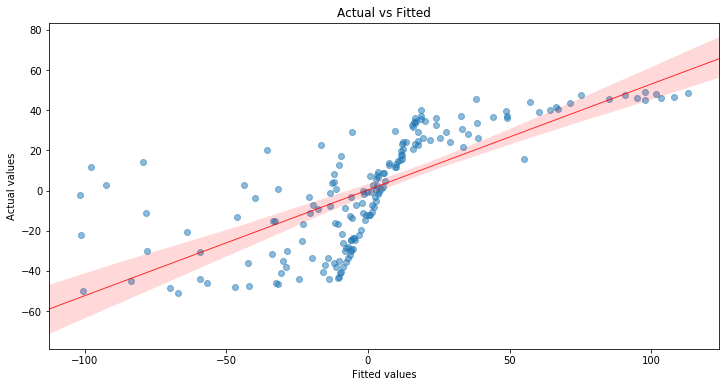

In [62]:
# Goodness-of-fit

plt.figure(figsize = (12, 6))


sns.regplot(y_train4, train_predictions4, 
                          scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

# plt.plot(y_train, train_predictions, 'o', color='blue')

plt.title('Actual vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Actual values')


Points are not symmetrically close to the diagonal line. This might mean the relation between dependant variable and independant variables is not truly linear as assumed. The would result in model's incapability to capture the true relation and the model would not able to explain variability of the dependant (response) data around its mean. <br />
That is why adjusted r2 of the model is low - around 40%-50% .


## Constant Variance of Residuals (Homoscedasticity)
 This plot would tell if there is an anomaly in residuals against fitted values. If a pattern, i.e upward trend or "fan" shape, exists, that would violate the constant error rule, which is call homoscedasticity. Error should spread randomly and they should be constant. <br />
 If the assumption does not hold, the interpretation of coefficients would be misleading. i.e. too wide/narrow confidence interval.

Text(0, 0.5, 'Residuals')

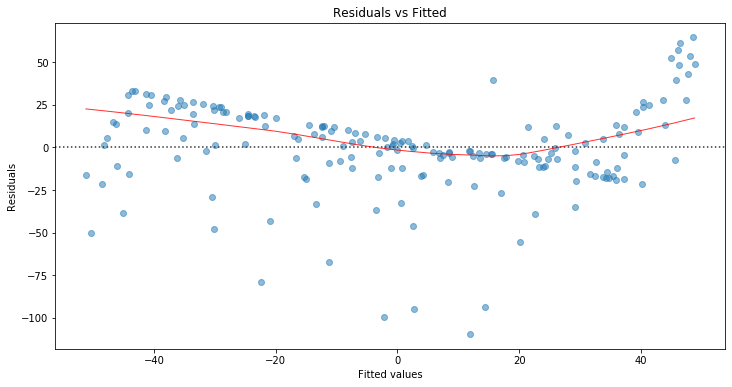

In [63]:
# Plotting homoscedasticity

error = y_train4 - train_predictions4

plt.figure(figsize = (12, 6))

sns.residplot(train_predictions4, error, lowess=True, 
                          scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})


plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')



There seems to be pattern here: When fitted values are close to 0, then residuals are smaller. As fitted values get bigger, or smaller, residuals get bigger. Also, it looks like a bowl shape, which might be an indication of a systematic error in the model.

## Zero Mean of Residuals

Then mean of residuals should be 0. Intuitevely speaking, the difference between actual points above the predicted line and the predicted line itself and the difference between actual points below the predicted line and the predicted line itself should offset each other, which ends up zero sum of residuals. 


In [64]:
residuals = y_train4 - train_predictions4
print('Mean of Residuals is {:0.3f}'.format(residuals.mean()))

Mean of Residuals is 0.000


Residual zero mean assumption hold.

## Normality Assumption

QQ plot helps see if the residuals are normally distributed. Normality assumption is critical since linear regression relies on normality (of error). If this assumption is violated, inferences related to parameters would be misleading, i.e wrong confidence intervals. 
Formal way of normality check is through Anderson-Darling normality test. The hypothesis is: <br />
    - H0: Residuals are normally distributed   
    - H1: Residuals are not normally distributed 
For the sake of brevity and simplification, let's stick to informal check, which is QQ plot. This way of diagnosis is more of a visuals rather than of a p-values

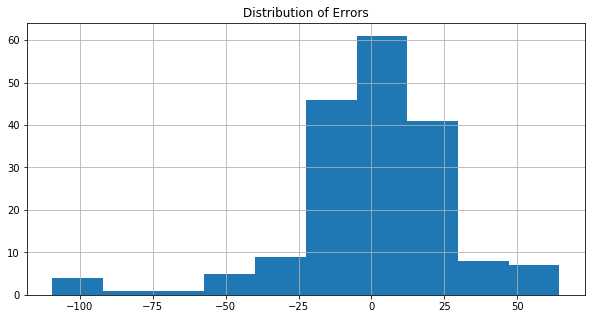

In [65]:
## Histogram of residuals

plt.figure(figsize = (10, 5))

plt.title("Distribution of Errors")
error.hist()

Distribution of errors has a left skewed.  <br />
QQ plot would reveal more.

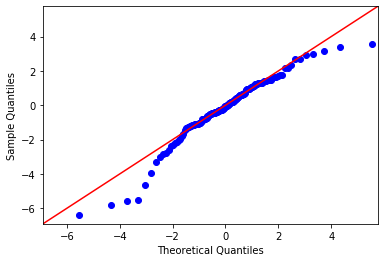

In [66]:
## QQ Plot
import statsmodels.api as sm
import scipy.stats as stats

sm.qqplot(error, stats.t, fit = True, line='45')
plt.show()

QQ plot shows that it is left skewed. <br />
As a further improvement,features can be transformed, i.e log transformation, to retrieve a normal distibution for errors. 

### Independence Assumption

Durbin-Watson test will help assess the condition of independence as a formal diagnostic. Autocorrelation plot would reveal if residualls are correlated or ont. If the data are not a time-series, we don't have to worry too much about this condition. <br />
Plotting residuals by time would be the informal way.


Text(0, 0.5, 'Residuals')

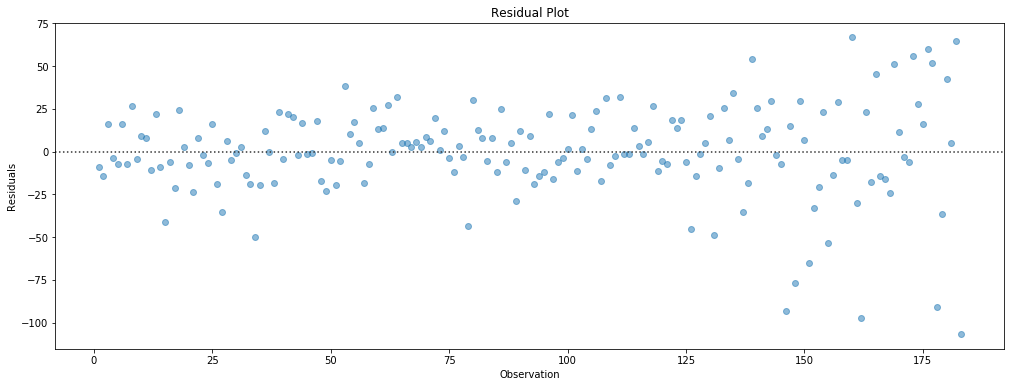

In [67]:
# Plotting residuals by time

x = np.linspace(1,len(y_train4),len(y_train4))

plt.figure(figsize = (17, 6))

sns.residplot(x, error, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
# plt.scatter(x, error)

plt.title('Residual Plot')
plt.xlabel('Observation')
plt.ylabel('Residuals')

Well, it is hard to realize a positive, or negative, autocorrelation by just looking at this plot - although someone can say there is a pattern. That is the downside of informal methods. It can be subjective and relies on visuals. <br />Autocorrelation plot and Durbin-Watson test would be more robust approach. For brevity, we are not going in that details.

## Multicollinearity

In multiple linear regression, multicollinearity happens if an independant variable can be predicted by any other independant variable through linear prediction with high accuracy. If it exists, coefficients would not be reliable and change in one parameter would have an inflated affect on another parameter. However, multicollinearity does not impact the predictive power and r2 of the model. <br /> <br />
Variance inflation factor (VIF) helps measure multicollinearity. There is not a formal upper limit for it. Some professionals accept 5, some accept 10. However, one thing for sure is that none of them accept the model if VIF is greater than 10.

In [68]:
# Model 4 with df_4: With outlier range 3

X_A = X_train4[['A']]
y_B = X_train4['B']


# Calculating beta values
betas_AB= linear_regression(X_A, y_B)
print('Beta Values {}'.format(betas_AB))

# Predictions for train and test data
predictions_AB = predict(X_A, betas_AB)

# Measuring performance, and printing the result
r2 = r2_score(y_B, predictions_AB)
print("r2: {:0.2f}".format(r2))

Beta Values [ 2.171583   -0.15456859]
r2: 0.07


In [69]:
vif = 1 / (1-r2)

print("VIF between Column A and Column B is {:0.2f}".format(vif))

VIF between Column A and Column B is 1.07


A VIF around 1 is very good. That means multicollinearity is not an issue.

## 7. From Linear Regression to Polynomial Regression

Adding polynomial features can improve the model. Let continue with df_4 this time and add some polynomial features. <br />
Note that log transformation, Box-Cox transformation etc. can improve the model as well.

In [70]:
# df_4: With outlier range 3
X = df_4[['A', 'B']]
y = df_4['C']


## Adding some polynomial features
X['A_squared'] = X['A']**2
X['AB'] = X['A']*X['B']
X['B_squared'] = X['B']**2

X.head()

,A,B,A_squared,AB,B_squared
0,0.490142,-0.179654,0.240240,-0.088056,0.032276
1,-1.414793,-1.225605,2.001639,1.733977,1.502107
2,0.943066,4.506148,0.889373,4.249593,20.305365
3,3.569090,5.068347,12.738400,18.089386,25.688145
4,-1.702460,6.905051,2.898370,-11.755575,47.679735


In [72]:

# Train - test split
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X , y, test_ratio= 0.33)

# Calculating beta values
betas_poly= linear_regression(X_train_poly, y_train_poly)
print('Beta Values {}'.format(betas_poly))

# Predictions for train and test data
train_predictions_poly = predict(X_train_poly, betas_poly)
test_predictions_poly = predict(X_test_poly, betas_poly)

# Measuring performance, and printing the result
print("Adjusted r2 for train set: {:0.2f}".format(adjusted_r2(X_train_poly, y_train_poly, train_predictions_poly)))
print("Adjusted r2 for test set: {:0.2f}".format(adjusted_r2(X_test_poly, y_test_poly, test_predictions_poly)))

print("MSE for train set: {:0.2f}".format(mse(y_train_poly, train_predictions_poly)))
print("MSE for test set: {:0.2f}".format(mse(y_test_poly, test_predictions_poly)))

Beta Values [ 15.16265796   4.35229962 -10.93522552  -0.24701101  -1.52150618
   0.40446956]
Adjusted r2 for train set: 0.71
Adjusted r2 for test set: 0.61
MSE for train set: 508.04
MSE for test set: 879.42


Adding polynimal features contributed to the predictive power of the model since the relation was curvilinear, hence adjusted r2 increase from 52% to 71% for train data, from 43% to 61% for test data, which is a great improvement. 
<br /> <br />
As a further improvement more features can be added and different transformations can be applied. <br /> <br />
(It is even possible to develop a non-linear regression.)



Diagnostic check for Polynomial Regression can be conducted as done above. These are: <br />
    - The behavior of a dependent variable should be explained by and additive relationship between the dependent variable and independant variable, and it should be linear or curvilinear.
    - The relationship between dependent variable and any independent variable should linear or curvilinear (polynomial in this contest)
    - The independent variables are independent of each other (no multicollinearity)
    - The errors are independent, normally distributed with mean zero and a constant variance (Ordinary Least Squares, which is the model we developed above )
Actually, these are almost same with the assumptions of Linear Regression, except curvilinear relation.

PS: Although it is not done here, Column A and Column C, or Column B and Column C, can be used to build a simple linear regression
and can be analyzed.